autoencoder: https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798 \
autoencoder: https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%203%20-%20Autoencoders.ipynb \
Unet: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5 \
Convolutional autoencoder maths: https://pgaleone.eu/neural-networks/2016/11/24/convolutional-autoencoders/ \
Convolutional autoencoder code: https://blog.keras.io/building-autoencoders-in-keras.html

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import os, os.path
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout
import math

In [10]:
def makeLines(array):
#     lineStart=5
#     lineEnd=18
#     arrayLines=np.copy(array)
#     for i in range(lineStart, lineEnd):
#         arrayLines[i] = np.full_like(array[i], np.nan)
#     return arrayLines
    specificLinesIndexes = np.array([2,5,6,9,10,11,14,17,19])
    arrayLines=np.copy(array)
    for index in specificLinesIndexes:
        arrayLines[index] = np.full_like(array[index], np.nan)
    return arrayLines

In [39]:
numberOfFiles=0
try: 
    filesXtrain = os.listdir('../TrainingDataset/x_train/'); 
    numberOfFiles = len(filesXtrain)
except: print('File not found')
numberOfFiles-=1
testingSetSize = 100
mx_train_lines = np.empty((numberOfFiles-testingSetSize,24,144))
mx_train = np.empty((numberOfFiles-testingSetSize,24,144))
mx_train_lines_nan = np.empty((numberOfFiles-testingSetSize,24,144))
mx_test_lines = np.empty((testingSetSize,24,144))
mx_test_lines_nan = np.empty((testingSetSize,24,144))
mx_test = np.empty((testingSetSize,24,144))
mx_test_infos = np.empty((testingSetSize,7), dtype="O")
mx_test_base = np.empty((testingSetSize,24,144))
allArrays = []
for i in range(numberOfFiles):
    allArrays.append(np.load('../TrainingDataset/x_train/Y2_{}.npy'.format(i), allow_pickle=True, encoding="latin1"))
allArrays = np.asarray(allArrays)

for i in range(0,numberOfFiles-testingSetSize):
    mx_train[i] = allArrays[i][1]
    mx_train_lines[i] = makeLines(mx_train[i])
    mx_train_lines_nan[i] = makeLines(mx_train[i])
for i in range(numberOfFiles-testingSetSize,numberOfFiles):
    mx_test[i-(numberOfFiles-testingSetSize)-1] = allArrays[i][1]
    mx_test_lines[i-(numberOfFiles-testingSetSize)-1] = makeLines(mx_test[i-(numberOfFiles-testingSetSize)-1])
    mx_test_lines_nan[i-(numberOfFiles-testingSetSize)-1] = makeLines(mx_test[i-(numberOfFiles-testingSetSize)-1])
    mx_test_infos[i-(numberOfFiles-testingSetSize)-1] = allArrays[i][2]
    mx_test_base = allArrays[i][0]

mx_train_lines=np.nan_to_num(mx_train_lines)
mx_train=np.nan_to_num(mx_train)
mx_test_lines=np.nan_to_num(mx_test_lines)
mx_test=np.nan_to_num(mx_test)

/home/pl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """
/home/pl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


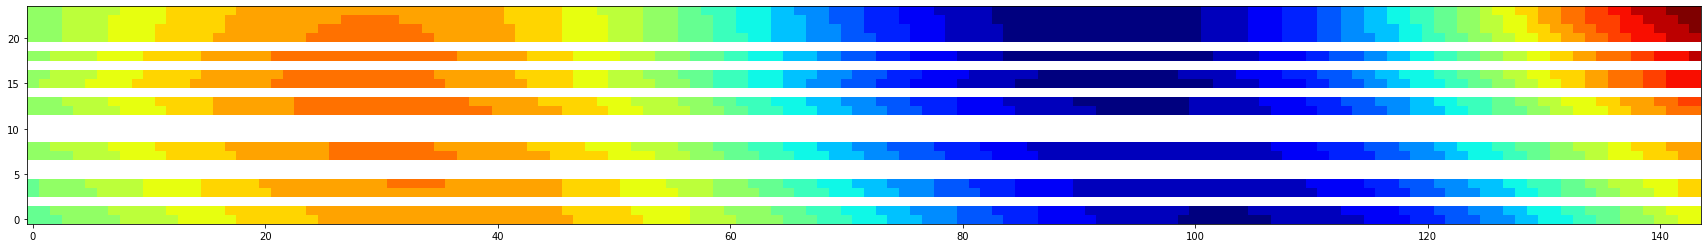

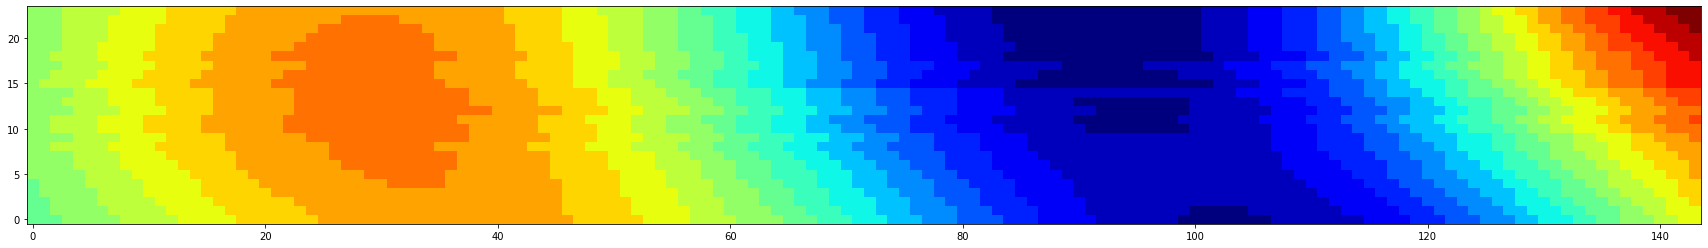

In [14]:
fileNumber = 90

fig= plt.figure(figsize=(30,4))
plt.imshow(mx_test_lines_nan[fileNumber], origin='lower', cmap=plt.get_cmap('jet', 20) , aspect='auto')
fig.show()

fig= plt.figure(figsize=(30,4))
plt.imshow(mx_test[fileNumber], origin='lower', cmap=plt.get_cmap('jet', 20) , aspect='auto')
fig.show()

In [18]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([24, 144, 1], input_shape=[24, 144], name="1"),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu", name="2_First_convolution"),
    keras.layers.Dropout(0.001, name="3_First_Dropout"),
    keras.layers.MaxPool2D(pool_size=2, name="4_First_Max_Pooling"),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu", name="5_Second_Convolution"),
    keras.layers.MaxPool2D(pool_size=2, name="6_Second_Max_Pooling"),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="relu", name="7_Third_Convolution"),
])
conv_decoder = keras.models.Sequential([
    keras.layers.Dense(128, input_shape=[6, 36, 128], name="1_Neural_Layer_128"),
    keras.layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding="VALID", activation="relu", name="2_First_Conv2DTranspose"),
    keras.layers.Conv2DTranspose(64, kernel_size=1, strides=1, padding="SAME", activation="relu", name="3_Second_Conv2DTranspose"),
    keras.layers.Dropout(0.001, name="4_First_Dropout"),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="relu", name="5_Third_Conv2DTranspose"),
    keras.layers.Conv2DTranspose(32, kernel_size=1, strides=1, padding="SAME", activation="relu", name="6_Fourth_Conv2DTranspose"),
    keras.layers.Conv2DTranspose(1, kernel_size=1, strides=1, padding="SAME", activation="sigmoid", name="7_Fifth_Conv2DTranspose"),
    keras.layers.Reshape([24, 144], name="8_Reshape_Output")
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [24]:
opt = keras.optimizers.Adam(learning_rate=0.001)
conv_ae.compile(loss="mse", optimizer=opt)
conv_ae.fit(mx_train_lines, mx_train, epochs=1, batch_size=512, shuffle=True)
# history = conv_ae.fit(mx_train_lines, mx_train, epochs=5, batch_size=1, shuffle=True)

Epoch 1/1
6399/6399 [==============================] - 54s 8ms/step - loss: 0.0064


In [45]:
numberOfPlots = 10
# fig, axs = plt.subplots(numberOfPlots,3, figsize=(25, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.1)

# axs = axs.ravel().reshape(numberOfPlots,3)
testPlotsIndex = 10
for y in range(numberOfPlots):
    prediction = conv_ae.predict(np.expand_dims(mx_test_lines[testPlotsIndex+y],0)).reshape(24,144)
    for i in range(mx_test_lines_nan[testPlotsIndex+y].shape[0]):
        if np.sum(mx_test_lines_nan[testPlotsIndex+y][i]) is math.nan:
            mx_test_lines_nan[testPlotsIndex+y][i] = prediction[i]
        
    finalArray = np.array([mx_test_base[testPlotsIndex+y], mx_test[testPlotsIndex+y], mx_test_lines_nan[testPlotsIndex+y], prediction, mx_test_infos[testPlotsIndex+y]])
    np.save("AE_training_results/AE_training_matrix{}".format(y), finalArray)
    
#         axs[y][0].imshow(mx_test[testPlotsIndex+y], origin='lower', cmap=plt.get_cmap('jet') , aspect='auto')
#         axs[y][0].set_title("Truth")
#         axs[y][1].imshow(mx_test_lines_nan[testPlotsIndex+y], origin='lower', cmap=plt.get_cmap('jet') , aspect='auto')
#         axs[y][1].set_title("Truth with gaps")
#         axs[y][2].imshow(conv_ae.predict(np.expand_dims(mx_test_lines[testPlotsIndex+y],0)).reshape(24,144), origin='lower', cmap=plt.get_cmap('jet') , aspect='auto')
#         axs[y][2].set_title("CAE reconstruction")

# fig.suptitle("{} reconstructions of X2 with a Deep Convolutional Autoencoder network based on a {} samples training set".format(numberOfPlots, numberOfFiles),fontsize=20)
# fig.savefig("Predictions")

In [24]:
#CONVOLUTIONAL AUTOENCODER OLD VERSION

input_img = keras.Input(shape=(20, 144, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 1), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

convolutional_autoencoder = keras.Model(input_img, decoded)
convolutional_autoencoder.compile(optimizer='adam', loss='mse')

convolutional_autoencoder._get_distribution_strategy = lambda: None
convolutional_autoencoder.fit(mx_train_lines, mx_train, epochs=10, batch_size=5, shuffle=True)

NotImplementedError: Cannot convert a symbolic Tensor (max_pooling2d_9/MaxPool:0) to a numpy array.

In [ ]:
# PLOT WITH RMSE

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer

RMSE_array_true=np.full([numberOfPlots*mx_test.shape[1],1],np.nan)
RMSE_array_pred=np.full([numberOfPlots*mx_test.shape[1],1],np.nan)

numberOfPlots = 10
fig, axs = plt.subplots(numberOfPlots,3, figsize=(25, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel().reshape(numberOfPlots,3)
testPlotsIndex = 60
for y in range(numberOfPlots):
    
        for i in range(mx_test.shape[1]):
            RMSE_array_pred = np.append(RMSE_array_pred,conv_ae.predict(np.expand_dims(mx_test_lines[testPlotsIndex+y],0)).reshape(20,144))
            RMSE_array_true = np.append(RMSE_array_true,mx_test[testPlotsIndex+y])
            
            imp = Imputer(missing_values=np.nan, strategy='mean')
            RMSE_array_pred=imp.fit_transform(RMSE_array_pred.reshape(RMSE_array_pred.shape[0],1)).reshape(RMSE_array_pred.shape[0])
            RMSE_array_true=imp.fit_transform(RMSE_array_true.reshape(RMSE_array_true.shape[0],1)).reshape(RMSE_array_true.shape[0])
            
            PRMSE = np.round(mean_squared_error(RMSE_array_true,RMSE_array_pred),5)
    
    
        axs[y][0].imshow(mx_test[testPlotsIndex+y], origin='lower', cmap=plt.get_cmap('jet', 20) , aspect='auto')
        axs[y][0].set_title("Truth")
        axs[y][1].imshow(mx_test_lines_nan[testPlotsIndex+y], origin='lower', cmap=plt.get_cmap('jet', 20) , aspect='auto')
        axs[y][1].set_title("Truth with gaps")
        axs[y][2].imshow(conv_ae.predict(np.expand_dims(mx_test_lines[testPlotsIndex+y],0)).reshape(20,144), origin='lower', cmap=plt.get_cmap('jet', 20) , aspect='auto')
        axs[y][2].set_title("CAE reconstruction, accuracy: {}%".format(PRMSE))
fig.savefig("Predictions")